In [1]:
# base code from 
# 1: https://docs.opencv.org/4.x/da/d0c/tutorial_bounding_rects_circles.html
# 2: https://pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/
# 3: https://www.geeksforgeeks.org/python/python-play-a-video-using-opencv/

In [2]:
# import the necessary packages
from scipy.spatial import distance as dist  # provides functions for computing distances
from collections import OrderedDict 
import numpy as np  # y'all already know
from __future__ import print_function
import cv2 as cv
import argparse
import random as rng
import matplotlib.pyplot as plt

In [3]:
def thresh_callback(val, frame):
    threshold = val
    maxR = 10**(-4)
    canny_output = cv.Canny(frame, threshold, threshold * 2)

    contours, _ = cv.findContours(canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # print(len(contours))

    contours_poly = [None]*len(contours)
    boundRect = []
    skipped = []
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])
        # print(radius[i])
        # if radius[i] <= maxR:
        boundRect.append(cv.boundingRect(contours_poly[i]))
        # else:
        #     skipped.append(c)
        # print(len(boundRect[i]))      

    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

    for i in range(len(boundRect)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours_poly, i, color)
        cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        # cv.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

    # cv.imshow('Contours', drawing)
    # print(boundRect)
    return boundRect

In [4]:
class CentroidTracker():
	def __init__(self, maxDisappeared=100):
		self.objects = OrderedDict()
		self.nextObjectID = 0
		self.disappeared = OrderedDict()
		self.Positions = OrderedDict()
		self.maxDisappeared = maxDisappeared
	
	def update_Positions(self,frameNumber,CX,CY):
		objectIDs = list(CX.keys())
    	# objectCentroids = list(self.objects.values())
		for ID in objectIDs:
			if ID in self.Positions:
				self.Positions[ID] = np.append(self.Positions[ID],np.array([[frameNumber,CX[ID],CY[ID]]]),axis=0)
			else:
				self.Positions[ID] = np.array([[frameNumber,CX[ID],CY[ID]]])
	
	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1
	
	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]
	
	def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1
				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)
			# return early as there are no centroids or tracking info
			# to update
			return self.objects

        # initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype='int')
        # loop over the bounding box rectangles
		CX = OrderedDict()
		CY = OrderedDict()
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

        # if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])
        # otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())
			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)
			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value is at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()
			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]

            # in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()
			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue
				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				CX[objectID] = inputCentroids[col][0]
				CY[objectID] = inputCentroids[col][1]
				self.disappeared[objectID] = 0
				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)
			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)   
            # in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1
					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)
            # otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])
		# return the set of trackable objects
		return self.objects, CX, CY

In [5]:
def areaOverlap(rect1, rect2):  # returns None if rectangles don't intersect
    dx = min(rect1[0]+rect1[2], rect2[0]+rect2[2]) - max(rect1[0], rect2[0])
    dy = min(rect1[1], rect2[1]) - max(rect1[1]-rect1[3], rect2[1]-rect2[3])
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

def init_video(filename, thresh):
    
    #set up constants and empty lists
    numGuys = []
    perimeters = []
    t=0
    a=1;
    
    #initialize centroid tracker
    cTracker = CentroidTracker()

    # Create a VideoCapture object and read from input file

    cap = cv.VideoCapture(filename)
    
    # Check if camera opened successfully
    if (cap.isOpened()== False):
        print("Error opening video file")

    kernel1 = cv.getStructuringElement(cv.MORPH_RECT,(a,a))
    kernel2 = cv.getStructuringElement(cv.MORPH_CROSS,(a,a))
    kernel3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(a,a))
    
    while(cap.isOpened()):
        t+=1
        print(t)
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            # this block zeros all non-pink pixels
            hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            sensitivity = 150
            lower_white = np.array([150, 85, 255-sensitivity])
            upper_white = np.array([200, 255, 255])
            mask = cv.inRange(hsv, lower_white, upper_white)
            inv_mask = cv.bitwise_not(mask)
            frame = cv.bitwise_and(frame, frame, mask = mask)
            
            # turns all non-black pixels white
            black_color = np.array([0, 0, 0])
            non_black_mask = np.any(frame != black_color, axis=-1)
            frame[non_black_mask] = [255, 255, 255]
            
            #dilates the white pixels (kernel,a, & number of iterations should be played with)
            #frame = cv.erode(frame, kernel3,iterations = 1)
            frame = cv.dilate(frame, kernel3,iterations = 3)
            
            #gets ALL rectangles
            rects = thresh_callback(thresh, frame)
            rectsToUse = []
            color = (255,0,0)
            Rcolor = (0,0,255)

            for i in range(len(rects)):
                contour = rects[i]
                p = 2*contour[2]+2*contour[3]
                perimeters.append(p)
                
                #thresholds the perimeters to not include tiny boxes
                if p > 50:
                    
                    rectsToUse.append(contour)
                    
            #print(len(rectsToUse))
            boolsInside = np.zeros(len(rectsToUse))
            for i in range(len(rectsToUse)):
                rect1 = rectsToUse[i]
                if boolsInside[i]==1:
                    continue
                    
                for j in range(len(rectsToUse)):
                    rect2 = rectsToUse[j]
                    if i==j:
                        continue
                    overlap = areaOverlap(rect1,rect2)
                    area1 = rect1[2]*rect1[3]
                    area2 = rect2[2]*rect2[3]
                    
                    if overlap>(area2/2.0):
#                         print("area2 = " + str(area2))
#                         print("overlap = " + str(overlap))
#                         print(rect1)
#                         print(rect2)
                        boolsInside[j] = 1
                    elif overlap>(area1/2.0):
#                         print("area1 = "+str(area1))
                        boolsInside[i] = 1

                    
            temp = []            
            for i in range(len(rectsToUse)):
                contour = rectsToUse[i]
                if boolsInside[i]==0:
                    temp.append(contour)
                    cv.rectangle(frame, (int(contour[0]), int(contour[1])),
                                 (int(contour[0]+contour[2]), int(contour[1]+contour[3])), color, 2)
                else:
                    cv.rectangle(frame, (int(contour[0]), int(contour[1])),
                                 (int(contour[0]+contour[2]), int(contour[1]+contour[3])), Rcolor, 2)
            rectsToUse = temp
            #print(len(rectsToUse))
            #print(np.sum(boolsInside))
            
            #sets up the waitkey
            # Press Q on keyboard to exit

            if cv.waitKey(25) & 0xFF == ord('q'):
                break
                
            #if there are no rectangles above threshold perimeter move on
            if not rectsToUse:
                continue
            
            cv.imshow('frame', frame)
            
            #update the tracker
            objects,CX,CY = cTracker.update(rectsToUse)
            numGuys.append(len(rectsToUse))
            
            #keep track of positions
            cTracker.update_Positions(t,CX,CY)
            

    # Break the loop
        else:
            break
    
    # When everything done, release
    # the video capture object
    cap.release()
    cv.destroyAllWindows()
    
    #histograms the perimeters
    plt.hist(perimeters,bins=50)
    plt.show() 
    
    #histograms the number of rectangles we're counting
    plt.hist(numGuys,bins=20)
    plt.show()
    
    #cTracker.Positions contains a dictionary n->arr
    #n is an integer keeping track of which object we're looking at
    #arr is a 2D array K rows, 3 columns; each row is OTF [time, x ,y]
    #K is the amount of tiqme for which the object is tracked
    
    
    return numGuys,cTracker.Positions

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


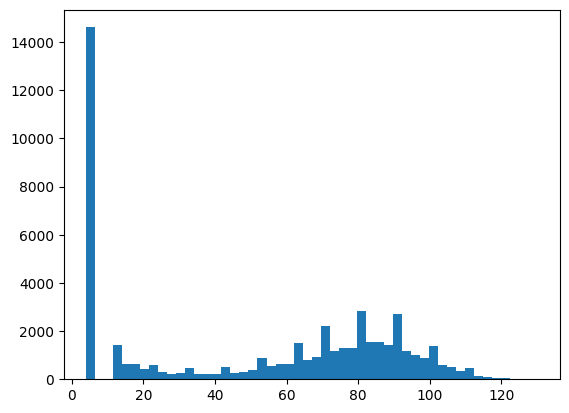

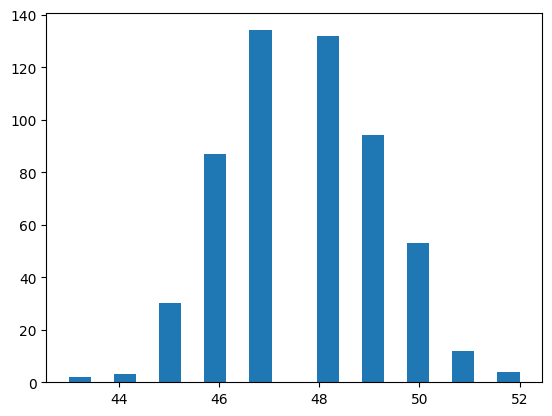

In [6]:
#threshold doesn't matter for these purposes because the frames are black and white
numGuys,pos = init_video("DroneVidsLamontFarm/13-02-clip8 (1).MP4", 100)

#there are actually 27 sheep in the vid
